# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#from fastai.imports import *
#from fastai.structured import *
#from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from sklearn import metrics
from pathlib import Path
import pandas as pd
import math
import seaborn as sns

from utils import *

In [3]:
from matplotlib import pyplot as plt, rcParams, animation

set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = Path('data') / 'bulldozers'

df_raw = pd.read_feather(PATH / 'bulldozers-raw.feather')
#df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [17]:
#imputation(categorify(df_raw))
df = df_pre(df_raw)

In [18]:
columns_cat = df_raw.select_dtypes('object').head().columns.values.tolist()
#columns_cont = df_raw.columns.symmetric_difference(columns_cat)

In [19]:
assert ((df.isnull().sum().sort_index()/len(df)) == 0).all(), 'pre-processing not valid'

In [8]:
#df_raw.fillna(df_raw[columns_cont].median(), inplace=True)

In [20]:
df_trn, y_trn = df.drop(columns=['SalePrice']), df.SalePrice

In [21]:
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [22]:
#def print_score(m):
#    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
#                m.score(X_train, y_train), m.score(X_valid, y_valid)]
#    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
#    print(res)

import pprint

def print_score(m):
    output = {
        'RMSE train' : rmse(m.predict(X_train), y_train),
        'RMSE val'   : rmse(m.predict(X_valid), y_valid),
        'R^2 train'  : m.score(X_train, y_train),
        'R^2 val'    : m.score(X_valid, y_valid)
    }
    if hasattr(m, 'oob_score_'): 
        output['R^2 oob'] = m.oob_score_
    
    pprint.pprint (output)

In [12]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,950,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1725,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,331,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,1,3674,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,3,4208,...,204,False,False,False,False,False,False,1248307200,False,False


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [23]:
from sklearn.ensemble import forest
# def set_rf_samples(n):
#     """ Changes Scikit learn's random forests to give each tree a random sample of
#     n random rows.
#     """
#     forest._generate_sample_indices = (lambda rs, n_samples:
#         forest.check_random_state(rs).randint(0, n_samples, n))

# def reset_rf_samples():
#     """ Undoes the changes produced by set_rf_samples.
#     """
#     forest._generate_sample_indices = (lambda rs, n_samples:
#         forest.check_random_state(rs).randint(0, n_samples, n_samples))
# set_rf_samples(50000)

In [ ]:
set_rf_samples(50000)

In [24]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.11924187137312084,
 'RMSE val': 0.22846266163556644,
 'R^2 oob': 0.9117829001392788,
 'R^2 train': 0.9702838602232089,
 'R^2 val': 0.9067865809297164}


In [31]:
def mlflow_log_randomforest_parameters(model):
    for param in ['n_estimators','min_samples_leaf','max_features','n_jobs']:
        print (f'{param}, {getattr(model, param, np.nan)}')
        #mlflow.log_param(param, getattr(model, param, np.nan))

In [32]:
mlflow_log_randomforest_parameters(m)

n_estimators, 40
min_samples_leaf, 3
max_features, 0.5
n_jobs, -1


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [ ]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [ ]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

In [ ]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();
#sns.countplot(x.Enclosure)

In [ ]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

In [ ]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

In [ ]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

In [ ]:
raw_valid.ProductSize.value_counts().plot.barh();

In [ ]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

In [ ]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [13]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [14]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [ ]:
#fi = rf_feat_importance(m, df_trn); fi[:10]
fi = rf_feat_importance(m, X_train); fi[:10]

In [ ]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [ ]:
plot_fi(fi[:30]);

In [ ]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

In [ ]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [ ]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

In [ ]:
#df_trn2, y_trn, nas = proc_df(df_raw.copy(), 'SalePrice', max_n_cat=7)

In [15]:
cc = df_raw[columns_cat].apply(lambda x:x.nunique()) < 7

In [16]:
columns_ohe = cc[cc].index.tolist()

In [17]:
df_trn2 = pd.concat([df.drop(columns=columns_ohe), pd.get_dummies(df_raw[columns_ohe])], axis=1).drop(columns=['SalePrice'])

In [18]:
df_trn2.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,Backhoe_Mounting_Yes,Differential_Type_Limited Slip,Differential_Type_Locking,Differential_Type_No Spin,Differential_Type_Standard,Steering_Controls_Command Control,Steering_Controls_Conventional,Steering_Controls_Four Wheel Standard,Steering_Controls_No,Steering_Controls_Wheel
0,1139246,999089,3157,121,3.0,2004,68.0,950,296,41,...,0,0,0,0,1,0,1,0,0,0
1,1139248,117657,77,121,3.0,1996,4640.0,1725,527,55,...,0,0,0,0,1,0,1,0,0,0
2,1139249,434808,7009,121,3.0,2001,2838.0,331,110,0,...,0,0,0,0,0,0,0,0,0,0
3,1139251,1026470,332,121,3.0,2001,3486.0,3674,1375,0,...,0,0,0,0,0,0,0,0,0,0
4,1139253,1057373,17311,121,3.0,2007,722.0,4208,1529,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X_train, X_valid = split_vals(df_trn2, n_trn)

In [20]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.1179601037570946,
 'RMSE val': 0.23374341202776955,
 'R^2 oob': 0.9104841989292581,
 'R^2 train': 0.9709192824789444,
 'R^2 val': 0.9024276572802282}


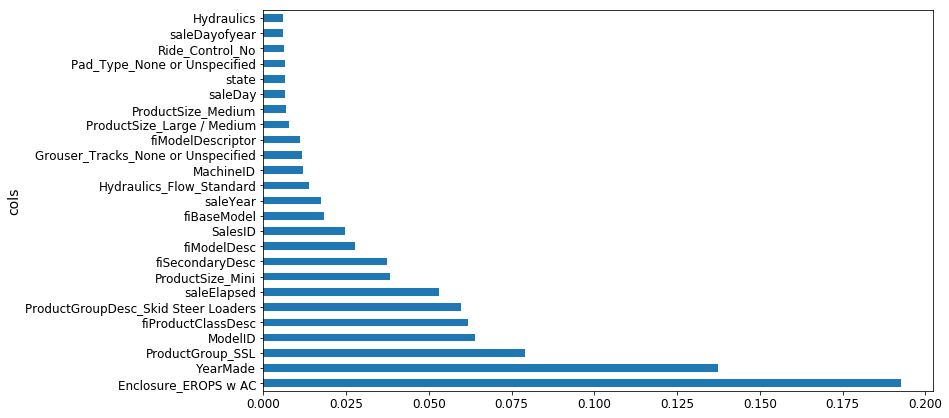

In [121]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [122]:
from scipy.cluster import hierarchy as hc
import scipy.stats

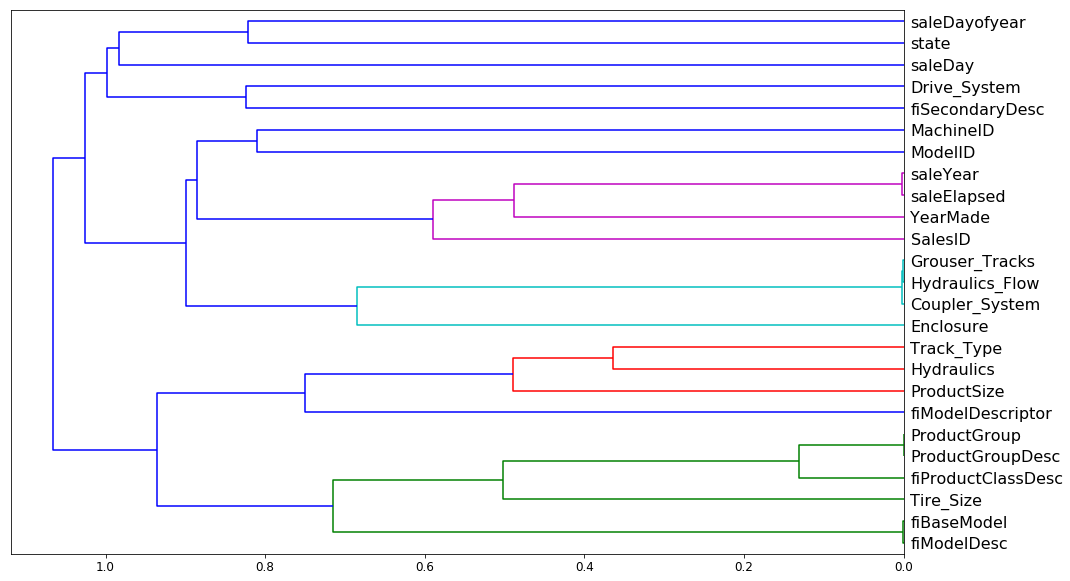

In [123]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [124]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [125]:
get_oob(df_keep)

0.8910395330706444

Now we try removing each variable one at a time.

In [126]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8899392337923852
saleElapsed 0.8874219303435298
fiModelDesc 0.8887168266258437
fiBaseModel 0.8893647599442147
Grouser_Tracks 0.8903909007641876
Coupler_System 0.8898974336510137


It looks like we can try one from each group for removal. Let's see what that does.

In [127]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8888208171573078

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [128]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [130]:
np.save('keep_cols.npy', np.array(df_keep.columns))

In [132]:
keep_cols = np.load('keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [133]:
reset_rf_samples()

In [134]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

C:\Users\fplopez\.conda\envs\mlservices\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'RMSE train': 0.12487796804555337,
 'RMSE val': 0.22606337948921593,
 'R^2 oob': 0.9084604481280353,
 'R^2 train': 0.9674083406019377,
 'R^2 val': 0.9087341284648083}


# Partial dependence

In [20]:
from pdpbox import pdp
import shap
shap.initjs()
#from plotnine import * # ggplot
#from ggplot import *

In [21]:
#set_rf_samples(50000)
reset_rf_samples()

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [22]:
#df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
#X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

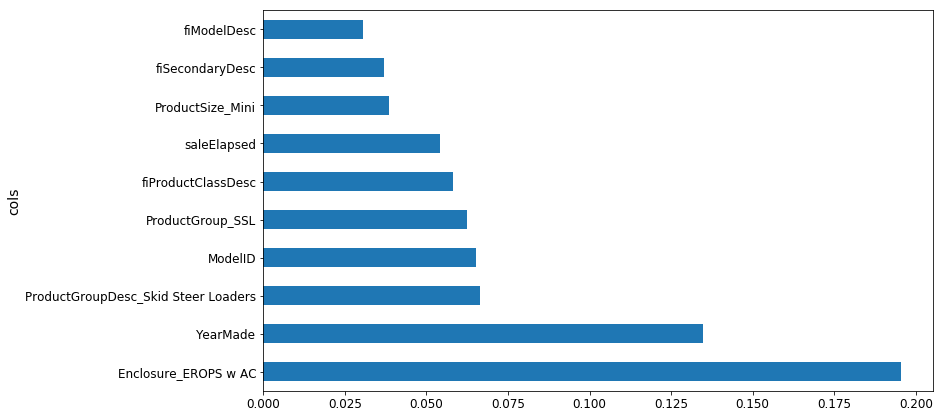

In [23]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

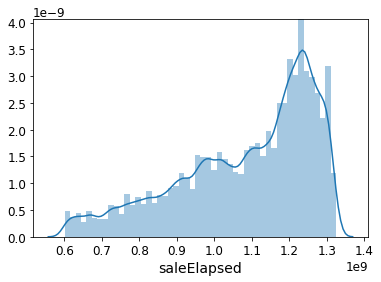

In [24]:
sns.distplot(X_train.saleElapsed)

In [25]:
column_year = X_train.YearMade.value_counts().sort_index() > 130
column_year = column_year[column_year].index.drop(1000)

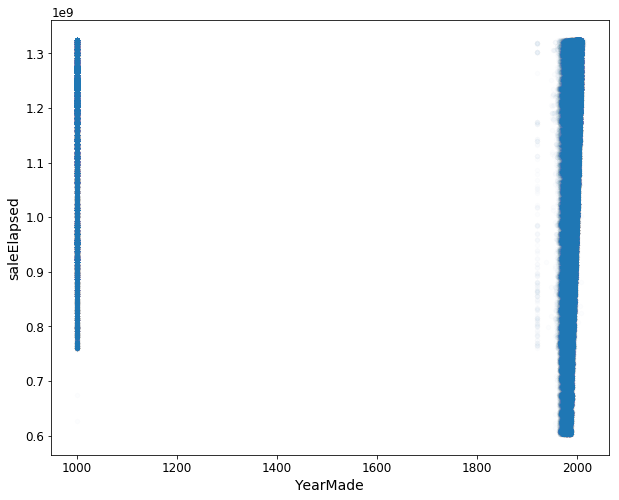

In [26]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [27]:
#x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)
x_all = df_raw[df_raw.YearMade.isin(column_year)].sample(500)

In [28]:
#ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [29]:
#x = get_sample(X_train[X_train.YearMade>1930], 500)
x = X_train[X_train.YearMade.isin(column_year)].sample(500)

In [ ]:
#feature_names = [i for i in df_raw.columns if df_raw[i].dtype in [np.int64]]
feature_names = df_raw.columns.values.tolist()
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature_names, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [30]:
explainer = shap.TreeExplainer(m)

In [36]:
shap_values = explainer.shap_values(x.iloc[0:100,:])

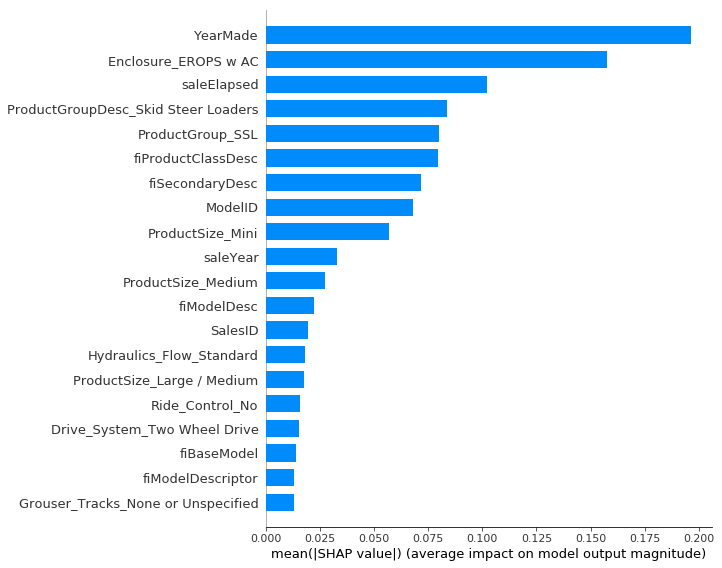

In [39]:
shap.summary_plot(shap_values, x.iloc[0:100,:], plot_type="bar")

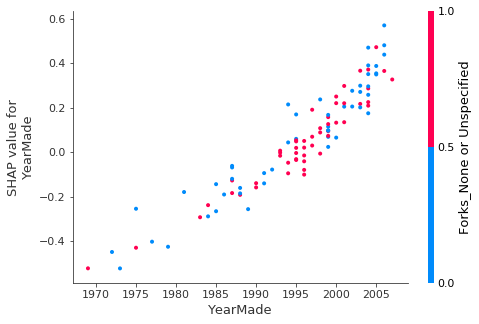

In [37]:
shap.dependence_plot("YearMade", shap_values, x.iloc[0:100,:])

In [ ]:
#plot_pdp('YearMade')

In [ ]:
#plot_pdp('YearMade', clusters=5)

In [ ]:
#feats = ['saleElapsed', 'YearMade']
#p = pdp.pdp_interact(m, x, feats)
#pdp.pdp_interact_plot(p, feats)

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(x.iloc[0:100,:])

In [ ]:
#shap.summary_plot(shap_interaction_values, X_train[['YearMade','saleElapsed']])
shap.dependence_plot(
    ("saleElapsed", "YearMade"),
    shap_interaction_values, x.iloc[0:100,:],
    display_features=x.iloc[0:100,:])

In [ ]:
#plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [ ]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [ ]:
#from treeinterpreter import treeinterpreter as ti

In [ ]:
#df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
#row = X_valid.values[None,0]; row

In [ ]:
#prediction, bias, contributions = ti.predict(m, row)

In [ ]:
#prediction[0], bias[0]

In [ ]:
#idxs = np.argsort(contributions[0])

In [ ]:
#[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

In [ ]:
#contributions[0].sum()

[slundberg/shap: A unified approach to explain the output of any machine learning model.](https://github.com/slundberg/shap)

In [47]:
x.iloc[0,:][['YearMade','ModelID','saleElapsed','ProductGroup_SSL','fiProductClassDesc','Enclosure_EROPS w AC']]

YearMade                      2001
ModelID                       3567
saleElapsed             1162425600
ProductGroup_SSL                 0
fiProductClassDesc               4
Enclosure_EROPS w AC             0
Name: 191, dtype: object

In [43]:
m.predict([x.iloc[0,:]]), 

array([10.33509505])

In [40]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x.iloc[0,:])

In [41]:
shap.force_plot(explainer.expected_value, shap_values, x.iloc[0:100])

# Extrapolation

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

In [ ]:
(X_valid[feats]/1000).describe()

In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
set_rf_samples(50000)

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)